### <a id='e'></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:350%;text-align:center;border-radius:15px 50px;padding:7px'> Rice Classification CNN by Pytorch</h1>

### Table of contents:

* [1. Import Libraries](#1)
* [2. Preparing Dataset](#2)
* [3. MODEL 1](#3)
* [4. MODEL 2](#4)
* [5. Best Model](#5)
* [6. Evaluate Final Model](#6)

<a id="1"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> Import Libraries</h1>

In [1]:
# install some requirement libraries
!pip install split-folders
!pip install torch-summary

In [2]:
# import requirement libraries and tools
import os
import pathlib
import numpy as np
import pandas as pd
import splitfolders
import itertools
import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

<a id="2"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> Preparing Dataset</h1>

In [3]:
# dataset path
dataset_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
dataset_path = pathlib.Path(dataset_path)

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        # Store the label for the image in the labels list
        labels.append(subfolder)
 
 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [4]:
df.head()

,image,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


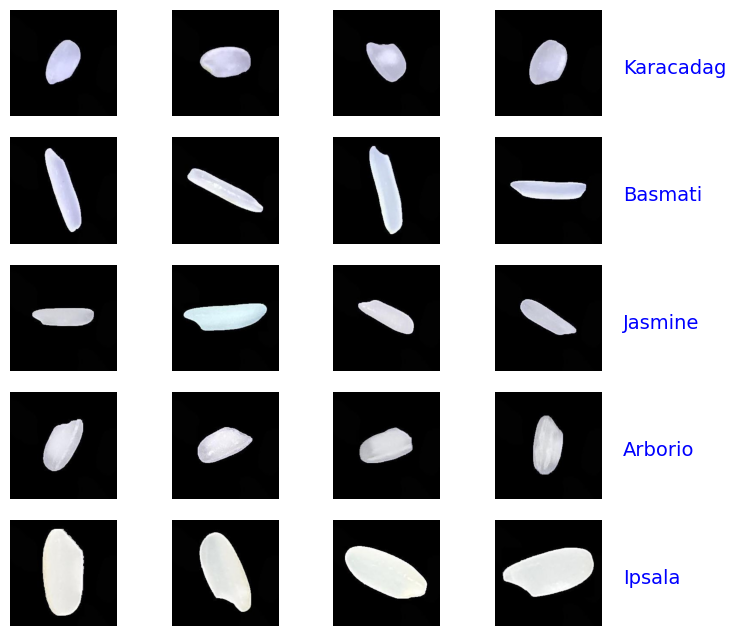

In [5]:
from matplotlib.gridspec import GridSpec
# Create figure and grid of subplots
fig = plt.figure(figsize=(8, 8))
gridspec = GridSpec(5, 4, figure = fig)

# Loop through each unique category in the DataFrame
for row, category in enumerate(df['label'].unique()):
    # Get the filepaths for the first four images in the category
    filepaths = df[df['label'] == category]['image'].values[:4]
    
    # Loop through the filepaths and add an image to each subplot
    for col, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gridspec[row, col])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    
    # Add a label to the bottom of the subplot grid
    ax.text(300, 150, category, fontsize = 14, color = 'blue')

plt.show()

## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Split Data into Train, Test and Validation</p>

In [6]:
%%time
# create folder for train, validation and test set
splitfolders.ratio(input=dataset_path, output='rice_images', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [06:45, 185.11 files/s]

CPU times: user 12.4 s, sys: 14.5 s, total: 26.9 s
Wall time: 6min 45s


## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Data Augmentation</p>

In [7]:
# new dataset path
image_working_dir = '/kaggle/working/rice_images'
image_working_dir = pathlib.Path(image_working_dir)

# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((250,250)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ]
)

# import and load train, validation and test set
Batch_Size = 32

train_set = torchvision.datasets.ImageFolder(image_working_dir.joinpath("train"), transform=transform)
print("Tarin", train_set, "\n")
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=Batch_Size, shuffle=True, num_workers=2)

val_set = torchvision.datasets.ImageFolder(image_working_dir.joinpath("val"), transform=transform)
print("Validation", val_set, "\n")
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=Batch_Size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.ImageFolder(image_working_dir.joinpath("test"), transform=transform)
print("Test", test_set, "\n")
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=Batch_Size, shuffle=True, num_workers=2)

# class_names = ("Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag")
classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4
}

Tarin Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /kaggle/working/rice_images/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Validation Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/rice_images/val
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Test Dataset ImageFolder
    Number of datapoints: 

In [8]:
# check class in each set
for i in [train_set, test_set, val_set]:
         print(i.classes)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [9]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

Validation data:
Shape of X : torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

Test data:
Shape of X : torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64



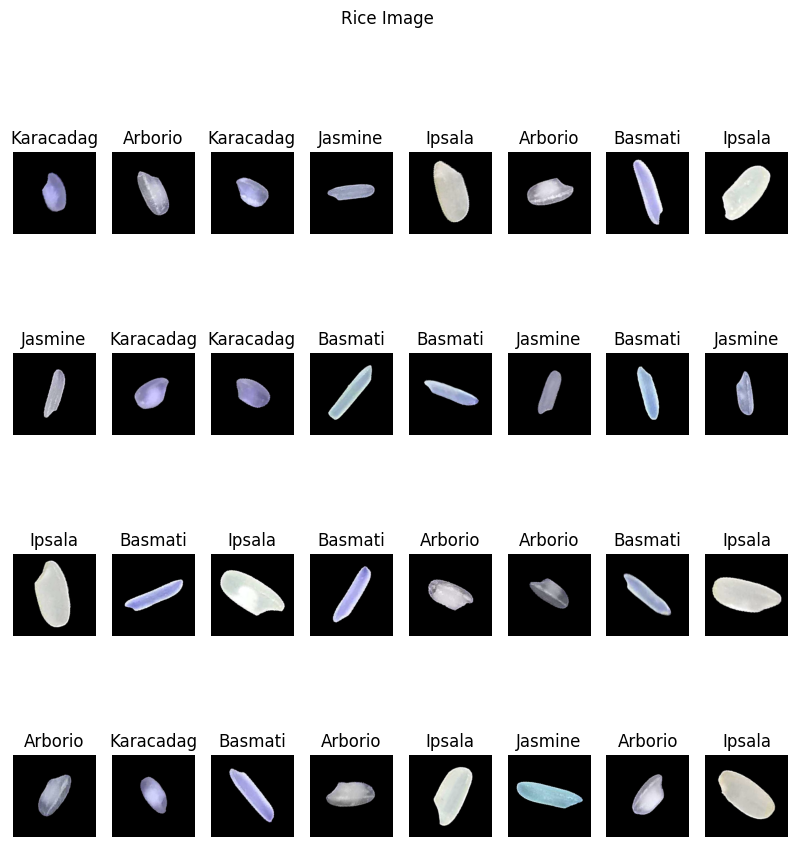

In [10]:
row = 4
col = 8

labels_list = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag",
}

# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.subplots(nrows = row, ncols = col, figsize = (10,10))
plt.suptitle('Rice Image', fontsize = 12)

for i in range(len(images)):  
    ax = plt.subplot(row, col, i+1)
    image_np = images[i].numpy().transpose(1, 2, 0)
    plt.imshow(np.clip(image_np, 0,1))
    
    label = labels_list[int(labels[i])]
    plt.title(label)
    plt.axis('off')
    
plt.show()

## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Device of Process</p>

In [11]:
# get Device for Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(f"Using {device} device")

Using cuda device


In [12]:
# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [13]:
# Moving data into GPU, WrappedDataLoader
train_dataloader = DeviceDataLoader(train_loader, device)
valid_dataloader = DeviceDataLoader(val_loader, device)

## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Definition of functions</p>

In [14]:
# define function for train model
def train(model, train_loader, validation_loader, device,
          loss_fn, optimizer, num_epochs, patience=3):
    """
    Train model on train loader:
        model: created model
        train_loader: train_set that load by DataLoader
        validation_loader: validation set that load by DataLoader
        device: available device for train model (cpu or cuda)
        loss_fn: defined loss function
        optimizer: defined optimizer
        num_epochs (int): number of epochs
        patience (int): for early stopping
    
    """
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    epoch = 0
    best_val_loss = float('inf')
    best_model_weights = None
    early_stopping_counter = 0

    while epoch < num_epochs and early_stopping_counter < patience:
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(enumerate(train_loader), ncols=600, total=len(train_loader))
        for batch_idx, (inputs, labels) in pbar:
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs} ')
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = evaluate(model, validation_loader, device, loss_fn)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f'train_loss: {train_loss:0.4f} | '
              f'train_acc: {train_acc:0.4f} | ' +
              f'val_loss: {val_loss:0.4f} | ' +
              f'val_acc: {val_acc:0.4f}', '\n')

        if history['val_loss'][-1] < best_val_loss:
            best_model_weights = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        best_val_loss = history['val_loss'][-1]
        epoch += 1

    return history, best_model_weights

In [15]:
def evaluate(model, data_loader, device, loss_fn):
    """
    Evaluate models and return loss and accuracy of model
        model: created model
        data_loader: test or validation loader
        device: available device for train model (cpu or cuda)
        loss_fn: defined loss function
    """

    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = total_loss / len(data_loader)
    val_acc = correct / total

    return val_loss, val_acc

In [16]:
def visualizing_results(model):
    """
    Plot diagram of accuracy and loss for train and validation set
        model: created model
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    
    # Plot train and validation accuracy
    axs[0].plot(model['history']['train_acc'], color='b', marker='o')
    axs[0].plot(model['history']['val_acc'], color='orange', marker='d')
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")
    
    # Plot train and validation loss
    axs[1].plot(model['history']['train_loss'], color='b', marker='o')
    axs[1].plot(model['history']['val_loss'], color='orange', marker='d')
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")
    
    plt.tight_layout()
    plt.show()

In [17]:
# define function for create two list include y_true and y_pred
def ture_and_pred_labels(dataloader, model):
    """
    Get out 2 list include y_true and y_pred for use in confusion_matrix
    """
    
    y_true = []
    y_pred = []
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

<a id="3"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> MODEL 1</h1>

In [19]:
# for calculating the accuracy
def model_acc(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
# Define first CNN Model: 1 conv layer | 1 pool layer | 2 full-connected layer | RelU activation
class Model1(nn.Module):
    def __init__(self, dim_output):
        super().__init__()

        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=32*124*124, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=dim_output),
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

model1 = Model1(5)

In [21]:
# print summary of model like summary in tensorflow
summary(model1, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 124, 124]        --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-4                       [-1, 500]                 246,016,500
|    └─ReLU: 2-5                         [-1, 500]                 --
|    └─Linear: 2-6                       [-1, 5]                   2,505
Total params: 246,019,901
Trainable params: 246,019,901
Non-trainable params: 0
Total mult-adds (M): 545.18
Input size (MB): 0.72
Forward/backward pass size (MB): 15.02
Params size (MB): 938.49
Estimated Total Size (MB): 954.23


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 124, 124]        --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-4                       [-1, 500]                 246,016,500
|    └─ReLU: 2-5                         [-1, 500]                 --
|    └─Linear: 2-6                       [-1, 5]                   2,505
Total params: 246,019,901
Trainable params: 246,019,901
Non-trainable params: 0
Total mult-adds (M): 545.18
Input size (MB): 0.72
Forward/backward pass size (MB): 15.02
Params size (MB): 938.49
Estimated Total Size (MB): 954.23

In [22]:
# mode model to GPU
model1 = model1.to(device)
model1

Model1(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=492032, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [23]:
# define a Loss function and optimizer for model1
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [24]:
# train model1
history1, model_weights1 = train(model1, train_loader, val_loader,
                                        device, loss, optimizer, num_epochs=20)

  0%|                                                                                                         …

train_loss: 0.2791 | train_acc: 0.9705 | val_loss: 0.0308 | val_acc: 0.9891 



  0%|                                                                                                         …

train_loss: 0.0421 | train_acc: 0.9867 | val_loss: 0.0448 | val_acc: 0.9860 



  0%|                                                                                                         …

train_loss: 0.0481 | train_acc: 0.9859 | val_loss: 0.0314 | val_acc: 0.9903 



  0%|                                                                                                         …

train_loss: 0.0355 | train_acc: 0.9889 | val_loss: 0.0384 | val_acc: 0.9876 



  0%|                                                                                                         …

train_loss: 0.0286 | train_acc: 0.9917 | val_loss: 0.1840 | val_acc: 0.9535 



  0%|                                                                                                         …

train_loss: 0.0294 | train_acc: 0.9910 | val_loss: 0.0175 | val_acc: 0.9943 



  0%|                                                                                                         …

train_loss: 0.0307 | train_acc: 0.9916 | val_loss: 0.0158 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0247 | train_acc: 0.9930 | val_loss: 0.0220 | val_acc: 0.9938 



  0%|                                                                                                         …

train_loss: 0.0276 | train_acc: 0.9927 | val_loss: 0.0175 | val_acc: 0.9951 



  0%|                                                                                                         …

train_loss: 0.0226 | train_acc: 0.9935 | val_loss: 0.0127 | val_acc: 0.9962 



  0%|                                                                                                         …

train_loss: 0.0254 | train_acc: 0.9935 | val_loss: 0.0199 | val_acc: 0.9935 



  0%|                                                                                                         …

train_loss: 0.0149 | train_acc: 0.9958 | val_loss: 0.0140 | val_acc: 0.9961 



  0%|                                                                                                         …

train_loss: 0.0219 | train_acc: 0.9945 | val_loss: 0.0117 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0286 | train_acc: 0.9934 | val_loss: 0.0208 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0140 | train_acc: 0.9962 | val_loss: 0.0145 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0194 | train_acc: 0.9946 | val_loss: 0.0115 | val_acc: 0.9966 



  0%|                                                                                                         …

train_loss: 0.0137 | train_acc: 0.9963 | val_loss: 0.0172 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0167 | train_acc: 0.9954 | val_loss: 0.0091 | val_acc: 0.9971 



  0%|                                                                                                         …

train_loss: 0.0152 | train_acc: 0.9958 | val_loss: 0.0120 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0135 | train_acc: 0.9960 | val_loss: 0.0113 | val_acc: 0.9966 



In [25]:
# create dict for store result of train models
histories = {}

# store train results
histories['Model 1'] = {'history':  history1, 'weights': model_weights1}

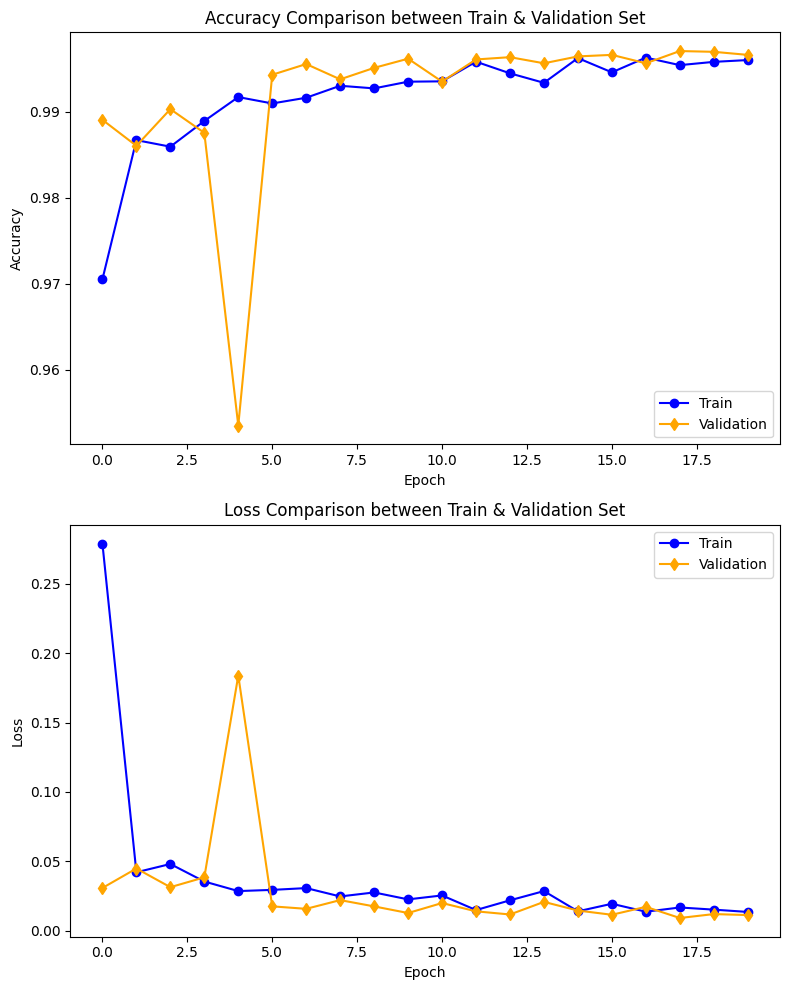

In [26]:
# plot accuracy and loss diagram per epoch for model1  
visualizing_results(histories['Model 1'])

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2250
         1.0       1.00      1.00      1.00      2250
         2.0       1.00      1.00      1.00      2250
         3.0       1.00      1.00      1.00      2250
         4.0       1.00      0.99      1.00      2250

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250
 




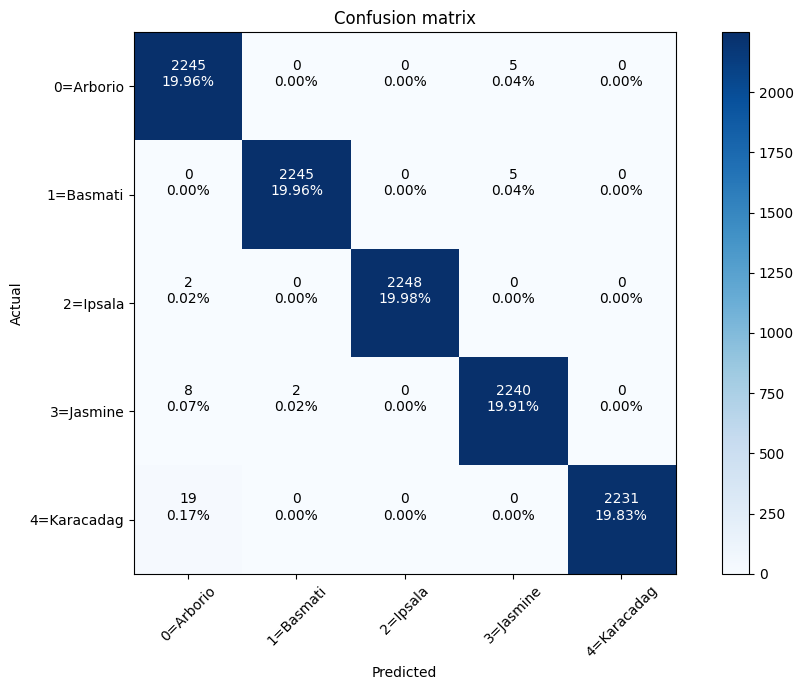

In [27]:
# check confusion matrix for error analysis
y_true, y_pred = ture_and_pred_labels(val_loader, model1)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues)

<a id="4"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> MODEL 2</h1>

In [28]:
# Define second CNN Model: by to conv layer and 2 pool layer
class Model2(nn.Module):
    def __init__(self, dim_output):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 59 * 59, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, dim_output)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model2 = Model2(5)

In [29]:
# show summary of model2
summary(model2, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 246, 246]         456
├─MaxPool2d: 1-2                         [-1, 6, 123, 123]         --
├─Conv2d: 1-3                            [-1, 16, 119, 119]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 59, 59]          --
├─Linear: 1-5                            [-1, 120]                 6,683,640
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 6,697,101
Trainable params: 6,697,101
Non-trainable params: 0
Total mult-adds (M): 67.91
Input size (MB): 0.72
Forward/backward pass size (MB): 4.50
Params size (MB): 25.55
Estimated Total Size (MB): 30.76


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 246, 246]         456
├─MaxPool2d: 1-2                         [-1, 6, 123, 123]         --
├─Conv2d: 1-3                            [-1, 16, 119, 119]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 59, 59]          --
├─Linear: 1-5                            [-1, 120]                 6,683,640
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 6,697,101
Trainable params: 6,697,101
Non-trainable params: 0
Total mult-adds (M): 67.91
Input size (MB): 0.72
Forward/backward pass size (MB): 4.50
Params size (MB): 25.55
Estimated Total Size (MB): 30.76

In [30]:
# mode model to GPU
model2 = model2.to(device)
model2

Model2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=55696, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [32]:
# define a Loss function and optimizer for model2
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [33]:
# train model2
history2, model_weights2 = train(model2, train_loader, val_loader,
                                        device, loss, optimizer, num_epochs=20, patience=5)

  0%|                                                                                                         …

train_loss: 0.0848 | train_acc: 0.9701 | val_loss: 0.0325 | val_acc: 0.9885 



  0%|                                                                                                         …

train_loss: 0.0410 | train_acc: 0.9866 | val_loss: 0.0248 | val_acc: 0.9932 



  0%|                                                                                                         …

train_loss: 0.0426 | train_acc: 0.9872 | val_loss: 0.0248 | val_acc: 0.9931 



  0%|                                                                                                         …

train_loss: 0.0264 | train_acc: 0.9922 | val_loss: 0.0313 | val_acc: 0.9886 



  0%|                                                                                                         …

train_loss: 0.0233 | train_acc: 0.9927 | val_loss: 0.0145 | val_acc: 0.9949 



  0%|                                                                                                         …

train_loss: 0.0389 | train_acc: 0.9901 | val_loss: 0.0165 | val_acc: 0.9950 



  0%|                                                                                                         …

train_loss: 0.0167 | train_acc: 0.9945 | val_loss: 0.0108 | val_acc: 0.9969 



  0%|                                                                                                         …

train_loss: 0.0182 | train_acc: 0.9950 | val_loss: 0.0171 | val_acc: 0.9954 



  0%|                                                                                                         …

train_loss: 0.0158 | train_acc: 0.9955 | val_loss: 0.0733 | val_acc: 0.9846 



  0%|                                                                                                         …

train_loss: 0.0224 | train_acc: 0.9935 | val_loss: 0.0104 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0161 | train_acc: 0.9957 | val_loss: 0.0179 | val_acc: 0.9942 



  0%|                                                                                                         …

train_loss: 0.0194 | train_acc: 0.9946 | val_loss: 0.0067 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0119 | train_acc: 0.9965 | val_loss: 0.0081 | val_acc: 0.9981 



  0%|                                                                                                         …

train_loss: 0.0155 | train_acc: 0.9959 | val_loss: 0.0083 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0176 | train_acc: 0.9953 | val_loss: 0.0115 | val_acc: 0.9965 



  0%|                                                                                                         …

train_loss: 0.0135 | train_acc: 0.9963 | val_loss: 0.0080 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0126 | train_acc: 0.9962 | val_loss: 0.0127 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0153 | train_acc: 0.9955 | val_loss: 0.0136 | val_acc: 0.9955 



  0%|                                                                                                         …

train_loss: 0.0123 | train_acc: 0.9964 | val_loss: 0.0093 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0141 | train_acc: 0.9962 | val_loss: 0.0722 | val_acc: 0.9838 



In [34]:
# store train results
histories['Model 2'] = {'history': history2, 'weights': model_weights2}

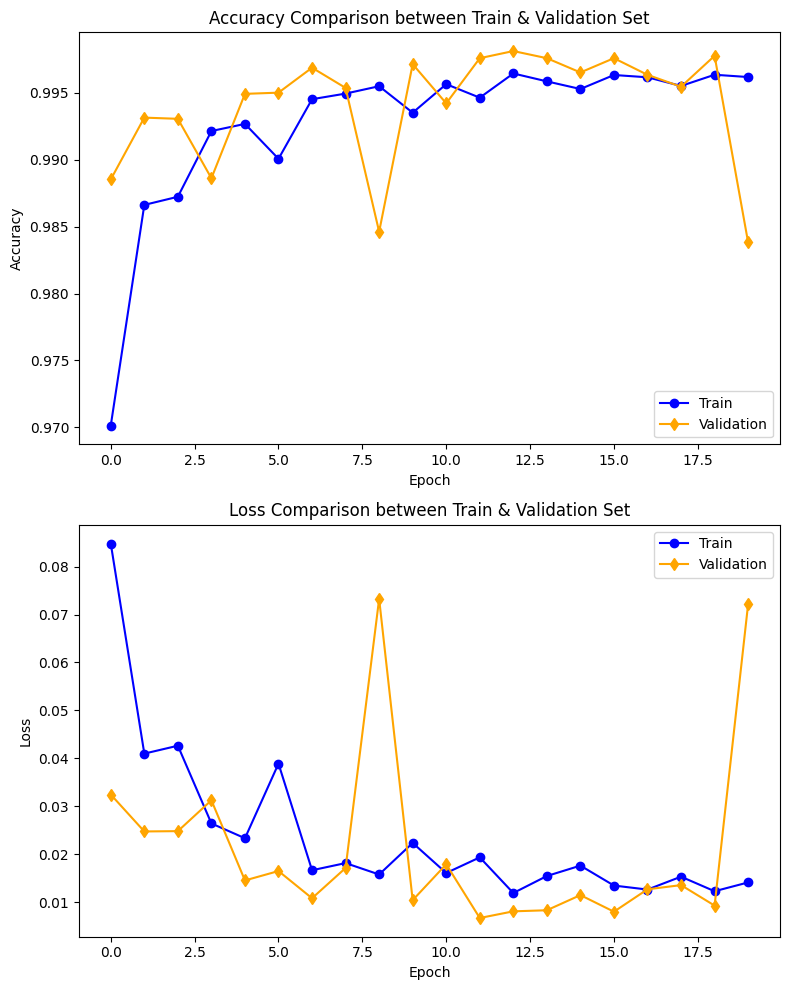

In [35]:
# plot accuracy and loss diagram per epoch for model2  
visualizing_results(histories['Model 2'])

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2250
         1.0       1.00      0.95      0.98      2250
         2.0       1.00      1.00      1.00      2250
         3.0       0.95      1.00      0.97      2250
         4.0       1.00      0.96      0.98      2250

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250
 




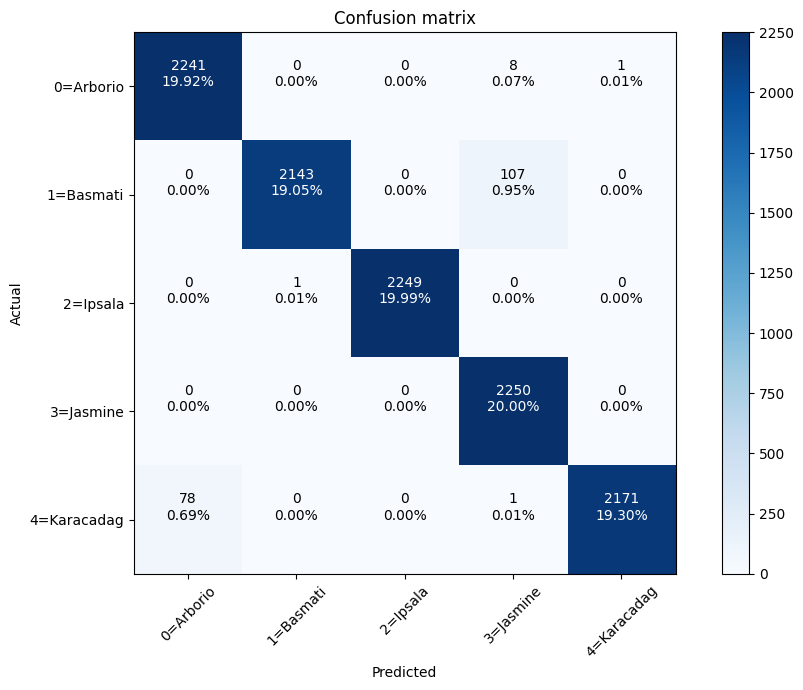

In [36]:
# check confusion matrix for error analysis
y_true, y_pred = ture_and_pred_labels(val_loader, model2)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues)

<a id="4"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> Best Model</h1>

In [37]:
# choose best model as final model
final_model = model2

# save final model
PATH = './cifar_net.pth'
torch.save(final_model.state_dict(), PATH)

<a id="5"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'>Evaluate Final Model</h1>

In [38]:
# evaluate model on unseen data (test set)
test_loss, test_acc = evaluate(final_model, test_loader, device, loss)

print(f'Loss of the network on the {len(test_loader.dataset)} test images: {test_loss:0.4f}')
print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {test_acc:0.4f}')

Loss of the network on the 11250 test images: 0.0900
Accuracy of the network on the 11250 test images: 0.9802
